# Goal

Goal of this competition is to classify argumentative elements in student writing as "effective", "adequate" or "ineffective" . You will create a model trained on data that is representative of the 6th-12th grade population in United States in order to minimize bias. Models derived from this competition will help pave way for students to receive feedback on their argumentative writing. With automated guidance, students can complete more assignments and ultimately become more confident, proficient writers.

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

import time
import datetime
from scipy import sparse


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import log_loss

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score,recall_score

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

%matplotlib inline

In [3]:
train = pd.read_csv('/extras/Data/feedback-prize/train.csv')
test = pd.read_csv('/extras/Data/feedback-prize/test.csv')
sample = pd.read_csv('/extras/Data/feedback-prize/sample_submission.csv')
print(f'Train_Shape: {train.shape},Test_Shape: {test.shape},Sample_Shape: {sample.shape}')
display(train.sample(2))
display(test.sample(2))
display(sample.sample(2))

Train_Shape: (36765, 5),Test_Shape: (10, 4),Sample_Shape: (10, 4)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
22826,f11c1bc18c1a,7203112033A1,I used to get bullied in school a lot but ever...,Evidence,Adequate
34272,a8f8734d87ff,4C6B05BD5A81,Staying home and doing online classes is fun b...,Counterclaim,Adequate


,discourse_id,essay_id,discourse_text,discourse_type
7,c668ff840720,D72CB1C11673,Seeking others opinion can be very helpful and...,Claim
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position


,discourse_id,Ineffective,Adequate,Effective
7,c668ff840720,1.0,2.0,3.0
6,84812fc2ab9f,3.0,6.0,1.0


In [4]:
train[train.essay_id=='490C2D42AFCE']

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
19887,007fd8eb752d,490C2D42AFCE,Mr. senator i think we should get rid of the e...,Position,Adequate
19888,42aec5c4b081,490C2D42AFCE,I know im not even old enough to vote yet and ...,Evidence,Ineffective
19889,18b6bb666f4e,490C2D42AFCE,The electoral college should vote for us becau...,Claim,Adequate
19890,7f78a20fa9a9,490C2D42AFCE,They say people of age and an american citazen...,Evidence,Ineffective


In [5]:
train[train.essay_id=='490C2D42AFCE']['discourse_text'].iloc[0]

'Mr. senator i think we should get rid of the electoral college and change to popular votefor the presidency. '

In [6]:
train[train.essay_id=='490C2D42AFCE']['discourse_text'].iloc[1]

'I know im not even old enough to vote yet and your probably thinking what is this kid talking about but i dont think it is right to vote for the president of the united states canidate and really not even vote for him. '

In [7]:
train[train.essay_id=='490C2D42AFCE']['discourse_text'].iloc[2]

'The electoral college should vote for us because believe it or not it isnt always the right desicion sometimes. '

In [8]:
train[train.essay_id=='490C2D42AFCE']['discourse_text'].iloc[3]

'They say people of age and an american citazen that we can vote then let them vote for who they want they shouldnt have to vote really for an elector people want to feel like there vote matters. The peoples votes should go right to the box and count the votes and see who wins. The electoral college is of no need for the election process we the people can vote for ourselfs please just let us. And i know it isnt really in the writing format the way they want it i just want you to know my oppinoin and i know your probably going to just skim right over this but please if you have the time just please read over this and take the time to understand were im coming from.    '

/home/puneet/Envs/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='discourse_type', ylabel='count'>

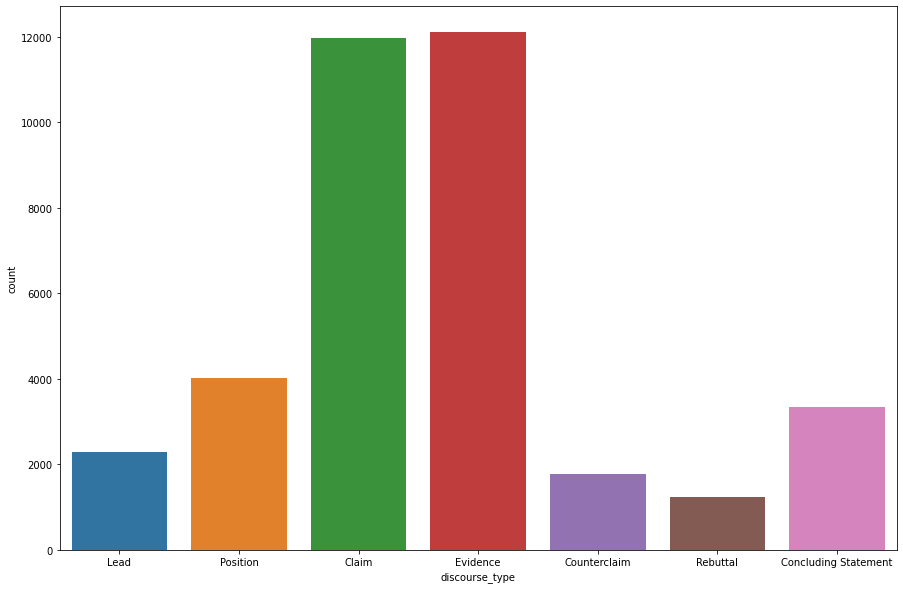

In [9]:
plt.figure(figsize=(15,10))
sns.countplot(train['discourse_type'])

/home/puneet/Envs/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='essay_id', ylabel='count'>

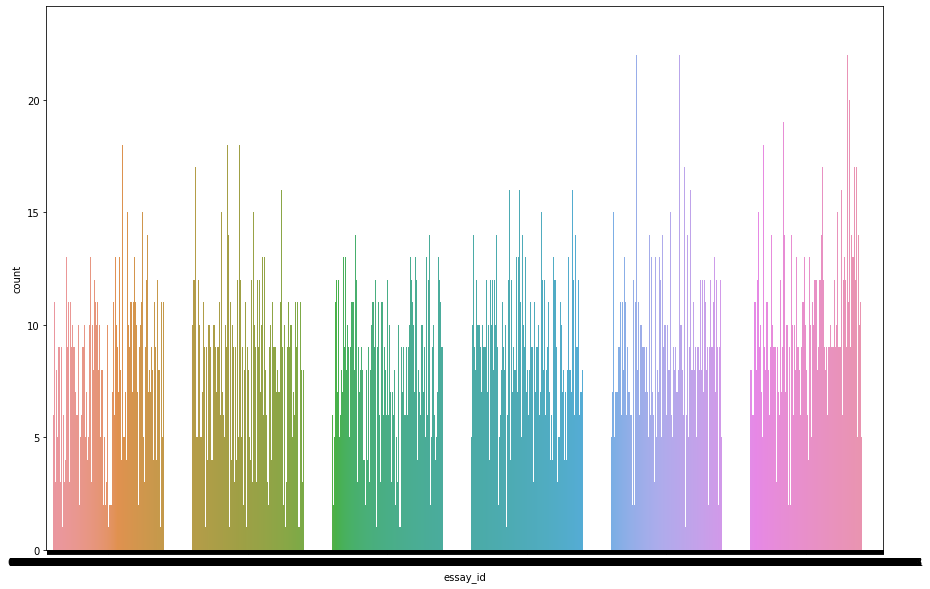

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(train['essay_id'])

# K Fold

In [11]:
#add extra one columns
train['kfold']=-1
#Distributing the data 5 shares
kfold = KFold(n_splits=5, shuffle= True, random_state = 42)
for fold, (train_indicies, valid_indicies) in enumerate(kfold.split(X=train)):
    #print(fold,train_indicies,valid_indicies)
    train.loc[valid_indicies,'kfold'] = fold

    
print(train.kfold.value_counts()) #total data 300000 = kfold split :5 * 60000

#output of train folds data
train.to_csv("trainfold_10.csv",index=False)

1    7353
4    7353
3    7353
0    7353
2    7353
Name: kfold, dtype: int64


In [12]:
train = pd.read_csv('./trainfold_10.csv')
train.tail(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,kfold
36763,cc184624ca8e,FFA381E58FC6,someone can use everything that many people sa...,Evidence,Ineffective,1
36764,c8a973681feb,FFA381E58FC6,In conclusion asking for an opinion can be ben...,Concluding Statement,Ineffective,2


# Data Preprocessing

In [13]:
def cleanup_text(text):
    words = re.sub(pattern = '[^a-zA-Z]',repl = ' ', string = text)
    words = words.lower()
    return words

cleanup_text('VK, is beast mode in my NLP competition ')

'vk  is beast mode in my nlp competition '

In [14]:
text_preprocessed = train['discourse_text'].apply(cleanup_text)
text_preprocessed
train['text_preprocessed'] = text_preprocessed
train.sample(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,kfold,text_preprocessed
24290,99f2f22c2604,8521B650F8A9,"Students that do not want to participate, must...",Evidence,Adequate,3,students that do not want to participate must...
9640,e08e8649feb4,AE6BABB53D5E,School is difficult as it is.,Claim,Adequate,0,school is difficult as it is


In [15]:
test_preprocessed = test['discourse_text'].apply(cleanup_text)
test_preprocessed
test['text_preprocessed'] =  test_preprocessed
test.head()

,discourse_id,essay_id,discourse_text,discourse_type,text_preprocessed
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead,making choices in life can be very difficult ...
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position,seeking multiple opinions can help a person ma...
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim,it can decrease stress levels
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim,a great chance to learn something new
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim,can be very helpful and beneficial


In [16]:
effectiveness_map = {'Ineffective' : 0, 'Adequate':1,'Effective':2}
train['target'] = train['discourse_effectiveness'].map(effectiveness_map)
train.sample(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,kfold,text_preprocessed,target
16467,943adcd9d908,1D10B524E194,I think that they should be aloud for only lun...,Position,Adequate,2,i think that they should be aloud for only lun...,1
16577,4523e92b7b42,1EF5AB00CBCB,Its not fair Texas gets 38 electoral but New Y...,Evidence,Adequate,4,its not fair texas gets electoral but new y...,1


# Training

In [17]:
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

In [18]:
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [19]:
model_nm = 'microsoft/deberta-v3-small'

In [20]:
tokz = AutoTokenizer.from_pretrained(model_nm)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
sep = tokz.sep_token
sep

'[SEP]'

In [22]:
train['inputs'] = train.discourse_type + sep +train.text_preprocessed

In [23]:
new_label = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}
train = train.replace(new_label)
train = train.rename(columns = {"discourse_effectiveness": "label"})

In [24]:
train.head()

,discourse_id,essay_id,discourse_text,discourse_type,label,kfold,text_preprocessed,target,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,1,1,hi i m isaac i m going to be writing about h...,1,Lead[SEP]hi i m isaac i m going to be writin...
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,1,4,on my perspective i think that the face is a ...,1,Position[SEP]on my perspective i think that t...
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,1,3,i think that the face is a natural landform be...,1,Claim[SEP]i think that the face is a natural l...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,1,1,if life was on mars we would know by now the...,1,Evidence[SEP]if life was on mars we would kno...
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,1,0,people thought that the face was formed by ali...,1,Counterclaim[SEP]people thought that the face ...


Now, let's create a dataset object

In [25]:
ds = Dataset.from_pandas(train)


In [26]:
def tok_func(x): return tokz(x["inputs"], truncation=True)


In [27]:
tok_func(ds[0])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [1, 8380, 2, 8595, 584, 1917, 269, 452, 6504, 584, 1917, 446, 264, 282, 898, 314, 361, 291, 812, 277, 57292, 269, 266, 1008, 1311, 9930, 289, 337, 343, 269, 432, 277, 57292, 272, 412, 278, 262, 697, 269, 314, 361, 35228, 452, 681, 266, 1355, 265, 57292, 263, 266, 812, 284, 757, 277, 262, 3568, 35228, 452, 702, 1941, 391, 337, 262, 1311, 9930, 284, 994, 293, 432, 277, 57292, 289, 337, 278, 269, 348, 266, 1008, 1311, 9930, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [28]:
train.head()

,discourse_id,essay_id,discourse_text,discourse_type,label,kfold,text_preprocessed,target,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,1,1,hi i m isaac i m going to be writing about h...,1,Lead[SEP]hi i m isaac i m going to be writin...
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,1,4,on my perspective i think that the face is a ...,1,Position[SEP]on my perspective i think that t...
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,1,3,i think that the face is a natural landform be...,1,Claim[SEP]i think that the face is a natural l...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,1,1,if life was on mars we would know by now the...,1,Evidence[SEP]if life was on mars we would kno...
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,1,0,people thought that the face was formed by ali...,1,Counterclaim[SEP]people thought that the face ...


In [29]:
inps = "text_preprocessed","discourse_type","kfold","discourse_text"
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','discourse_id','essay_id'))

  0%|          | 0/37 [00:00<?, ?ba/s]

In [30]:
tok_ds[0].keys()

dict_keys(['label', 'target', 'input_ids', 'token_type_ids', 'attention_mask'])

Now, we need to create a validation set. We will split based on essay_ids.

In [31]:
essay_ids = train.essay_id.unique()
np.random.seed(42)
np.random.shuffle(essay_ids)
essay_ids[:5]

array(['B5C606F0A883', 'FA4FE7706A1A', '37A77BEAD718', '0ED28D8A5EC4',
       'F25BA634ADDD'], dtype=object)

In [49]:
val_prop = 0.3
val_sz = int(len(essay_ids)*val_prop)
val_essay_ids = essay_ids[:val_sz]

In [50]:
is_val = np.isin(train.essay_id, val_essay_ids)
idxs = np.arange(len(train))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

(10824, 25941)

We can use `select` method of `Dataset` object to create our splits

In [51]:
dds = DatasetDict({"train":tok_ds.select(trn_idxs),
             "test": tok_ds.select(val_idxs)})

In [52]:
train.columns

Index(['discourse_id', 'essay_id', 'discourse_text', 'discourse_type', 'label',
       'kfold', 'text_preprocessed', 'target', 'inputs'],
      dtype='object')

In [53]:
def get_dds(df, train=True):
    ds = Dataset.from_pandas(df)
    to_remove = ['discourse_id', 'essay_id', 'discourse_text', 'discourse_type',
       'kfold', 'text_preprocessed', 'inputs']
    tok_ds = ds.map(tok_func, batched=True, remove_columns=to_remove)
    if train:
        return DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})
    else: 
        return tok_ds

In [54]:
lr,bs = 8e-5,8
wd,epochs = 0.01,1

In [55]:
from sklearn.metrics import log_loss
import torch.nn.functional as F
def score(preds): return {'log loss': log_loss(preds.label_ids, F.softmax(torch.Tensor(preds.predictions)))}

Now we can create Trainer object.

In [56]:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=3)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=score)

In [57]:
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25941
    })
    test: Dataset({
        features: ['label', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10824
    })
})

In [ ]:
trainer = get_trainer(dds)
trainer.train()

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

Epoch,Training Loss,Validation Loss


Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
added tokens file saved in outputs/checkpoint-500/added_tokens.json
/home/puneet/Envs/venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Saving model checkpoint to outputs/checkpoint-1000
Configuration saved in outputs/checkpoint-1000/config.json
Model weights saved in outputs/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-1000/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-1000/special_tokens_map

# Inference and submission

In [60]:
test['inputs'] = test.discourse_type + sep +test.text_preprocessed

In [62]:
test['kfold'] = 1

In [63]:
test_ds = get_dds(test,train=False)

  0%|          | 0/1 [00:00<?, ?ba/s]

Now that we have our `Dataset` object with our test dataset. Then we can simply perform `Trainer.predict` on our dataset to get the predictions.

In [64]:
preds = F.softmax(torch.Tensor(trainer.predict(test_ds).predictions)).numpy().astype(float)
preds

/home/puneet/Envs/venv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running Prediction *****
  Num examples = 10
  Batch size = 32


/tmp/ipykernel_449652/4215640471.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = F.softmax(torch.Tensor(trainer.predict(test_ds).predictions)).numpy().astype(float)


array([[0.01277519, 0.33581078, 0.65141404],
       [0.02656811, 0.54735756, 0.42607439],
       [0.01276022, 0.33722383, 0.65001595],
       [0.04685219, 0.66600323, 0.2871446 ],
       [0.03618533, 0.55889326, 0.40492135],
       [0.01331391, 0.28830099, 0.69838512],
       [0.00943603, 0.238768  , 0.75179601],
       [0.01924435, 0.43459085, 0.54616475],
       [0.03113047, 0.37629542, 0.59257418],
       [0.0096351 , 0.27761984, 0.71274507]])